## Master of Applied Data Science
### University of Michigan - School of Information
### Capstone Project - Rapid Labeling of Text Corpus Using Information Retrieval Techniques
### Fall 2021
#### Team Members: 
Chloe Zhang ([chloexyz@umich.edu](chloexyz@umich.edu)), 
Michael Penrose ([penrosem@umich.edu](penrosem@umich.edu)), 
Carlo Tak ([carlotak@umich.edu](carlotak@umich.edu))

### Experiment Flow

event type > count vectorizer > bigrams > remove english stop-words > 100 features > PyCaret > Naive Bayes

### Purpose

This notebook investigates how well a classifier can predict the **event type (i.e. 'earthquake', 'fire', 'flood', 'hurricane)** of the Tweets in the [Disaster tweets dataset](https://crisisnlp.qcri.org/humaid_dataset.html#) (Firoj Alam, Umair Qazi, Muhammad Imran and Ferda Ofli, HumAID: Human-Annotated Disaster Incidents Data from Twitter, In ICWSM, 2021).

This experiment has the following specific features:
- English stop-words are removed
- Unigrams and bigrams are used as features
- Only one underlying estimator (Naive Bayes) is used, instead of the multiple estimators that PyCaret usually uses.

This experiment was set up because once it was established (in a previous experiment) that it was possible to build a reasonably good classifier, it was desired to see how well a single estimator performs. Using this text vectorization (unigrams and bigrams) with a Naive Bayes estimator is considered a good first approach especially without little prior knowledge of the domain.

It should be noted that if the web application that is to be built on top of this classifier (or one like it) then the more the text is processed according to a specific domain, then the less general-purpose the application will be. 


### Summary

The Naïve Bayes classifier build in this notebook showed a decrease in performance compared to a previously built model that used an XGBoost estimator. The classifier had an Accuracy of 0.85 and an AUC score of 0.98.

There were 2,309 (out of 16,060) misclassified tweets in total. Compare this with the more accurate classifier which had 553 misclassified examples. 

Overall, the results still seemed reasonable – the web application build on top of a classifier that could help users rapidly label a large corpus of text with an accuracy of 0.85 seemed reasonable.


In [1]:
from utilities import dt_utilities as utils
from datetime import datetime

In [2]:
start_time = datetime.now()
start_time.strftime("%Y/%m/%d %H:%M:%S")

'2021/10/04 09:53:25'

In [3]:
consolidated_disaster_tweet_data_df = \
    utils.get_consolidated_disaster_tweet_data(root_directory="data/",
                                               event_type_directory="HumAID_data_event_type",
                                               events_set_directories=["HumAID_data_events_set1_47K",
                                                                       "HumAID_data_events_set2_29K"],
                                               include_meta_data=True)

In [4]:
consolidated_disaster_tweet_data_df

,tweet_id,class_label,event_type,data_type,tweet_text
0,798262465234542592,sympathy_and_support,earthquake,dev,RT @MissEarth: New Zealand need our prayers af...
1,771464543796985856,caution_and_advice,earthquake,dev,"@johnaglass65 @gordonluke Ah, woke up to a nig..."
2,797835622471733248,requests_or_urgent_needs,earthquake,dev,RT @terremotocentro: #eqnz if you need a tool ...
3,798021801540321280,other_relevant_information,earthquake,dev,RT @BarristerNZ: My son (4) has drawn a pictur...
4,798727277794033664,infrastructure_and_utility_damage,earthquake,dev,Due to earthquake damage our Defence Force is ...
...,...,...,...,...,...
76479,783991683188948992,infrastructure_and_utility_damage,hurricane,train,RT @LindsayLogue: 3500+ homes destroyed in Haiti
76480,783794225368276992,not_humanitarian,hurricane,train,"@ClintonFdn stay out of Haiti, you will not ge..."
76481,783399699994648576,other_relevant_information,hurricane,train,Hurricane-hit southern Haiti cut off after bri...
76482,783400762898391041,sympathy_and_support,hurricane,train,Please pray for these beautiful people.


In [5]:
train_df = consolidated_disaster_tweet_data_df[consolidated_disaster_tweet_data_df["data_type"]=="train"].reset_index(drop=True)

In [6]:
test_df = consolidated_disaster_tweet_data_df[consolidated_disaster_tweet_data_df["data_type"]=="test"].reset_index(drop=True)

In [7]:
dev_df = consolidated_disaster_tweet_data_df[consolidated_disaster_tweet_data_df["data_type"]=="dev"].reset_index(drop=True)

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.pipeline import Pipeline
import pandas as pd
from scipy.sparse import coo_matrix, hstack
import scipy.sparse
import numpy as np
from collections import Counter

In [9]:
num_features = 100
target_column = "event_type"
# vectorizer = TfidfVectorizer(max_features=num_features)
# count_vectorizer = CountVectorizer(max_features=num_features)

vectorizer = Pipeline([
    ("vectorizer", CountVectorizer(ngram_range=(1, 2), stop_words="english", max_features=num_features)),
#     ("reduce", SelectKBest(score_func=f_classif, k=num_features)), # chi2, f_classif
])

In [10]:
vectorizer.fit(train_df["tweet_text"], train_df[target_column])

Pipeline(steps=[('vectorizer',
                 CountVectorizer(max_features=100, ngram_range=(1, 2),
                                 stop_words='english'))])

In [11]:
def vectorized_tweet_data(fitted_vectorizer, source_df, text_column, target_column, 
                          vectorizer_name="vectorizer", reducer_name="reduce"):
    vectorized_data = fitted_vectorizer.transform(source_df[text_column])
    
    vectorized_df = pd.DataFrame.sparse.from_spmatrix(vectorized_data)
    
    all_feature_names = fitted_vectorizer.named_steps[vectorizer_name].get_feature_names()
    
    if reducer_name == "NONE":
        vectorized_df.columns = all_feature_names
    else:
        support = vectorizer.named_steps[reducer_name].get_support()
        feature_names = np.array(all_feature_names)[support]
        vectorized_df.columns = feature_names

    vectorized_df = vectorized_df.sparse.to_dense()

    # vectorized_df = vectorized_df.apply(pd.to_numeric)
    vectorized_df = vectorized_df.astype(float)

    vectorized_df["tweet_id"] = source_df["tweet_id"]
    vectorized_df["tweet_text"] = source_df["tweet_text"]
    vectorized_df[target_column] = source_df[target_column]

    return vectorized_df

In [12]:
train_vectorized_event_type_df = vectorized_tweet_data(fitted_vectorizer=vectorizer, 
                                                       source_df=train_df, 
                                                       text_column="tweet_text", 
                                                       target_column=target_column,
                                                       vectorizer_name="vectorizer", 
                                                       reducer_name="NONE")
train_vectorized_event_type_df

,000,affected,aid,amp,areas,bahamas,california,city,coast,county,cycloneidai,damage,dead,death,death toll,destroyed,disaster,donate,donations,dorian,earthquake,efforts,emergency,eqnz,evacuation,families,fires,flood,flooding,floods,florence,florida,food,fund,haiti,harvey,help,hit,home,homes,houston,hurricane,hurricane dorian,hurricane florence,hurricane harvey,hurricane irma,hurricane maria,hurricanedorian,hurricaneflorence,hurricaneharvey,hurricaneirma,hurricanemaria,irma,just,kerala,keralafloodrelief,keralafloods,killed,know,like,lost,make,maria,mexico,mozambique,nebraska,need,new,news,north,people,power,pray,prayers,puerto,puerto rico,relief,rescue,residents,rico,rt,safe,shelter,state,stay,storm,supplies,support,team,texas,thank,thoughts,time,today,toll,trump,victims,water,wildfire,wildfires,tweet_id,tweet_text,event_type
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,798064896545996801,I feel a little uneasy about the idea of work ...,earthquake
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,797913886527602688,#eqnz Interislander ferry docking aborted afte...,earthquake
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,797867944546025472,Much of New Zealand felt the earthquake after ...,earthquake
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,797958935126773760,"Noticing a lot of aftershocks on eqnz site, bu...",earthquake
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,797813020567056386,"RT @E2NZ: Mike Clements, NZ police, says obvio...",earthquake
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53526,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,

In [13]:
test_vectorized_event_type_df = vectorized_tweet_data(fitted_vectorizer=vectorizer, 
                                                       source_df=test_df, 
                                                       text_column="tweet_text", 
                                                       target_column=target_column,
                                                       vectorizer_name="vectorizer", 
                                                       reducer_name="NONE")
test_vectorized_event_type_df

,000,affected,aid,amp,areas,bahamas,california,city,coast,county,cycloneidai,damage,dead,death,death toll,destroyed,disaster,donate,donations,dorian,earthquake,efforts,emergency,eqnz,evacuation,families,fires,flood,flooding,floods,florence,florida,food,fund,haiti,harvey,help,hit,home,homes,houston,hurricane,hurricane dorian,hurricane florence,hurricane harvey,hurricane irma,hurricane maria,hurricanedorian,hurricaneflorence,hurricaneharvey,hurricaneirma,hurricanemaria,irma,just,kerala,keralafloodrelief,keralafloods,killed,know,like,lost,make,maria,mexico,mozambique,nebraska,need,new,news,north,people,power,pray,prayers,puerto,puerto rico,relief,rescue,residents,rico,rt,safe,shelter,state,stay,storm,supplies,support,team,texas,thank,thoughts,time,today,toll,trump,victims,water,wildfire,wildfires,tweet_id,tweet_text,event_type
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,798274825441538048,The earthquake in New Zealand was massive. Bil...,earthquake
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,798452064208568320,These pictures show the alarming extent of the...,earthquake
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,797804396767682560,Just woke to news of another earthquake! WTF N...,earthquake
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,798434862830993408,"When theres an actual earthquake, landslide an...",earthquake
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,797790705414377472,"Tsunami warning for entire East Coast of NZ, b...",earthquake
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15155,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,

In [14]:
dev_vectorized_event_type_df = vectorized_tweet_data(fitted_vectorizer=vectorizer, 
                                                       source_df=dev_df, 
                                                       text_column="tweet_text", 
                                                       target_column=target_column,
                                                       vectorizer_name="vectorizer", 
                                                       reducer_name="NONE")

In [15]:
import pycaret.classification as pc_class
RND_SEED = 39674
N_JOBS = 2
# include_models = ["nb", "lr", "gbc", "lightgbm"] # , "xgboost"
# exclude_models = ["knn", "svm", "ridge"]

numeric_features_adj = train_vectorized_event_type_df.columns.tolist()
numeric_features_adj = [x for x in numeric_features_adj if x not in [target_column, "tweet_id", "tweet_text"]]

In [16]:
exp_00 = pc_class.setup(train_vectorized_event_type_df, 
                        
                        numeric_features=numeric_features_adj,
#                         categorical_features=categorical_features,


                        silent=True,
                        verbose=False,

                        ignore_features=["tweet_id", "tweet_text"],
                        target=target_column, # "event_type", # "class_label"
                        session_id=RND_SEED,

                        n_jobs=N_JOBS)

INFO - PyCaret Supervised Module
INFO - ML Usecase: classification
INFO - version 2.3.0
INFO - Initializing setup()
INFO - setup(display=None, profile_kwargs=None, profile=False, verbose=False, silent=True, log_data=False, log_profile=False, log_plots=False, experiment_name=None, log_experiment=False, session_id=39674, html=True, custom_pipeline=None, use_gpu=False, n_jobs=2, fold_groups=None, fold_shuffle=False, fold=10, fold_strategy=stratifiedkfold, data_split_stratify=False, data_split_shuffle=True, transform_target_method=box-cox, transform_target=False, fix_imbalance_method=None, fix_imbalance=False, interaction_threshold=0.01, feature_ratio=False, feature_interaction=False, feature_selection_method=classic, feature_selection_threshold=0.8, feature_selection=False, group_names=None, group_features=None, polynomial_threshold=0.1, trigonometry_features=False, polynomial_degree=2, polynomial_features=False, cluster_iter=20, create_clusters=False, remove_perfect_collinearity=True, mu

In [17]:
best_model = pc_class.create_model("nb")
# best_model = pc_class.create_model("lightgbm")
# best_model = pc_class.create_model("lr")

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8642,0.9801,0.8864,0.8958,0.8706,0.7869,0.7968
1,0.8647,0.9829,0.8790,0.8953,0.8711,0.7871,0.7967
2,0.8626,0.9836,0.8888,0.8969,0.8692,0.7852,0.7963
3,0.8516,0.9813,0.8783,0.8865,0.8587,0.7693,0.7806
4,0.8513,0.9809,0.8838,0.8899,0.8588,0.7694,0.7819
5,0.8564,0.9821,0.8866,0.8910,0.8626,0.7767,0.7888
6,0.8591,0.9818,0.8880,0.8882,0.8635,0.7803,0.7915
7,0.8602,0.9806,0.8855,0.8940,0.8669,0.7814,0.7921
8,0.8580,0.9814,0.8794,0.8887,0.8641,0.7780,0.7881
9,0.8511,0.9820,0.8822,0.8872,0.8577,0.7691,0.7816


INFO - create_model_container: 1
INFO - master_model_container: 1
INFO - display_container: 2
INFO - GaussianNB(priors=None, var_smoothing=1e-09)
INFO - create_model() succesfully completed......................................


In [18]:
y_train = pc_class.get_config("y_train")
y_train

INFO - Initializing get_config()
INFO - get_config(variable=y_train)
INFO - Global variable: y_train returned as 25392    3
16418    2
15097    2
35125    3
2652     0
        ..
13558    1
35536    3
40614    3
27883    3
39469    3
Name: event_type, Length: 37471, dtype: int32
INFO - get_config() succesfully completed......................................


25392    3
16418    2
15097    2
35125    3
2652     0
        ..
13558    1
35536    3
40614    3
27883    3
39469    3
Name: event_type, Length: 37471, dtype: int32

In [19]:
y_test = pc_class.get_config("y_test")
y_test

INFO - Initializing get_config()
INFO - get_config(variable=y_test)
INFO - Global variable: y_test returned as 20453    2
892      0
43651    3
39427    3
13870    1
        ..
17174    2
4967     0
34935    3
11209    1
47010    3
Name: event_type, Length: 16060, dtype: int64
INFO - get_config() succesfully completed......................................


20453    2
892      0
43651    3
39427    3
13870    1
        ..
17174    2
4967     0
34935    3
11209    1
47010    3
Name: event_type, Length: 16060, dtype: int64

In [20]:
y = pc_class.get_config("y")
y

INFO - Initializing get_config()
INFO - get_config(variable=y)
INFO - Global variable: y returned as 0        0
1        0
2        0
3        0
4        0
        ..
53526    3
53527    3
53528    3
53529    3
53530    3
Name: event_type, Length: 53531, dtype: int64
INFO - get_config() succesfully completed......................................


0        0
1        0
2        0
3        0
4        0
        ..
53526    3
53527    3
53528    3
53529    3
53530    3
Name: event_type, Length: 53531, dtype: int64

In [21]:
original_labels = train_df[target_column]
original_labels

0        earthquake
1        earthquake
2        earthquake
3        earthquake
4        earthquake
            ...    
53526     hurricane
53527     hurricane
53528     hurricane
53529     hurricane
53530     hurricane
Name: event_type, Length: 53531, dtype: object

In [22]:
Counter(original_labels)

Counter({'earthquake': 6250, 'fire': 7792, 'flood': 7815, 'hurricane': 31674})

In [23]:
labels_map = dict(zip(y, original_labels))
labels_map

{0: 'earthquake', 1: 'fire', 2: 'flood', 3: 'hurricane'}

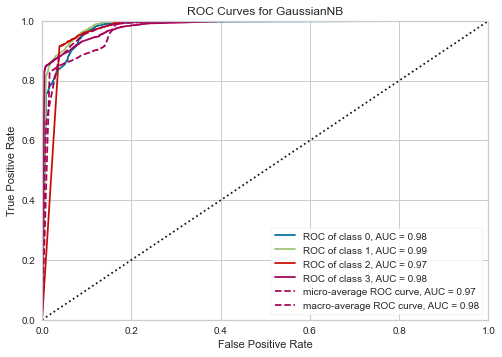

INFO - Visual Rendered Successfully
INFO - plot_model() succesfully completed......................................


In [24]:
try:
    pc_class.plot_model(best_model, "auc")
except:
    print(f"Could not plot model.")

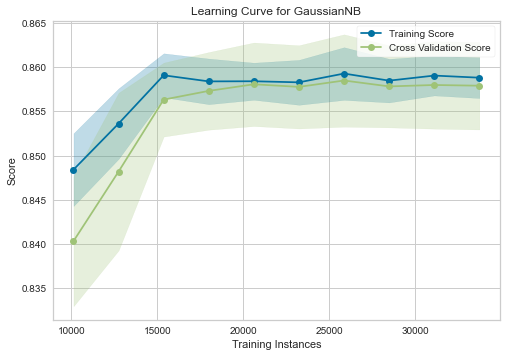

INFO - Visual Rendered Successfully
INFO - plot_model() succesfully completed......................................


In [25]:
try:
    pc_class.plot_model(best_model, "learning")
except:
    print(f"Could not plot model.")

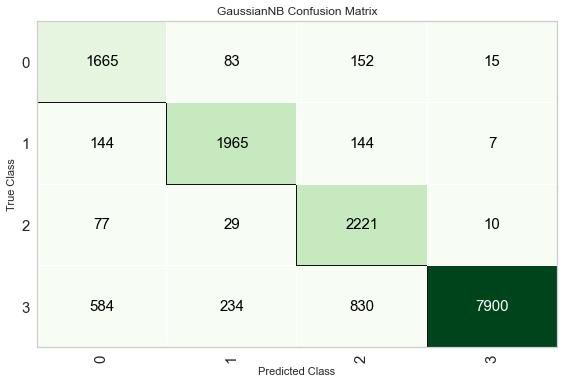

INFO - Visual Rendered Successfully
INFO - plot_model() succesfully completed......................................


In [26]:
try:
    pc_class.plot_model(best_model, "confusion_matrix")
except:
    print(f"Could not plot model.")

In [27]:
try:
    pc_class.plot_model(best_model, "feature")
except:
    print(f"Could not plot model.")

INFO - Initializing plot_model()
INFO - plot_model(is_in_evaluate=False, verbose=True, use_train_data=False, fold=None, plot=feature, system=True, scale=1, save=False, label=False, groups=None, fit_kwargs=None, feature_name=None, estimator=GaussianNB(priors=None, var_smoothing=1e-09), display_format=None, display=None)
INFO - Checking exceptions


Could not plot model.


In [28]:
try:
    pc_class.plot_model(best_model, "feature_all")
except:
    print(f"Could not plot model.")

INFO - Initializing plot_model()
INFO - plot_model(is_in_evaluate=False, verbose=True, use_train_data=False, fold=None, plot=feature_all, system=True, scale=1, save=False, label=False, groups=None, fit_kwargs=None, feature_name=None, estimator=GaussianNB(priors=None, var_smoothing=1e-09), display_format=None, display=None)
INFO - Checking exceptions


Could not plot model.


In [29]:
predictions_train = pc_class.predict_model(best_model)
predictions_train

INFO - Initializing predict_model()
INFO - predict_model(display=None, ml_usecase=MLUsecase.CLASSIFICATION, verbose=True, round=4, raw_score=False, encoded_labels=False, probability_threshold=None, estimator=GaussianNB(priors=None, var_smoothing=1e-09))
INFO - Checking exceptions
INFO - Preloading libraries
INFO - Preparing display monitor


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Naive Bayes,0.8562,0.9808,0.8792,0.8887,0.8626,0.7745,0.7853


,000,affected,aid,amp,areas,bahamas,california,city,coast,county,...,today,toll,trump,victims,water,wildfire,wildfires,event_type,Label,Score
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,flood,flood,1.0000
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,earthquake,earthquake,1.0000
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,hurricane,earthquake,0.8139
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,hurricane,hurricane,1.0000
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,fire,flood,1.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16055,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,flood,flood,1.0000
16056,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,earthquake,earthquake,1.0000
16057,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,hurricane,hurricane,1.0000
16058,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,fire,fire,1.0000


In [30]:
pd.set_option('max_colwidth', 400)
pd.set_option('display.max_columns', 500)

In [31]:
predictions_train_with_text = \
    pd.concat([
                
                predictions_train,
                train_df.iloc[y_test.index.to_list()][["tweet_text"]].reset_index(drop=True),
              ], axis=1)

predictions_train_with_text#.head(5)

,000,affected,aid,amp,areas,bahamas,california,city,coast,county,cycloneidai,damage,dead,death,death toll,destroyed,disaster,donate,donations,dorian,earthquake,efforts,emergency,eqnz,evacuation,families,fires,flood,flooding,floods,florence,florida,food,fund,haiti,harvey,help,hit,home,homes,houston,hurricane,hurricane dorian,hurricane florence,hurricane harvey,hurricane irma,hurricane maria,hurricanedorian,hurricaneflorence,hurricaneharvey,hurricaneirma,hurricanemaria,irma,just,kerala,keralafloodrelief,keralafloods,killed,know,like,lost,make,maria,mexico,mozambique,nebraska,need,new,news,north,people,power,pray,prayers,puerto,puerto rico,relief,rescue,residents,rico,rt,safe,shelter,state,stay,storm,supplies,support,team,texas,thank,thoughts,time,today,toll,trump,victims,water,wildfire,wildfires,event_type,Label,Score,tweet_text
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,flood,flood,1.0000,Low income flood victims being offered food benefits. -KFOR News
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,earthquake,earthquake,1.0000,"NZStuff: No tsunami threat to New Zealand after 7.3 magnitude earthquake hits off the coast of Fukushima, Japan"
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,hurricane,earthquake,0.8139,"Yesterday afternoon, VSL successfully handed over items donated to the victims of the mudslide via our website. Thx!"
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,hurricane,hurricane,1.0000,"22,000 packed into shelters in Lee County, Florida ahead of Hurricane Irma"
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,fire,flood,1.0000,"We’re joining hundreds of fellow breweries on #GivingTuesday in brewing Resilience IPA, a beer to support @SierraNevada and their efforts to raise funds for those affected by the Camp Fire in CA."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16055,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [32]:
predictions_train_with_text_misclassification = \
    predictions_train_with_text[predictions_train_with_text["event_type"]!=predictions_train_with_text["Label"]].reset_index(drop=True)

predictions_train_with_text_misclassification

,000,affected,aid,amp,areas,bahamas,california,city,coast,county,cycloneidai,damage,dead,death,death toll,destroyed,disaster,donate,donations,dorian,earthquake,efforts,emergency,eqnz,evacuation,families,fires,flood,flooding,floods,florence,florida,food,fund,haiti,harvey,help,hit,home,homes,houston,hurricane,hurricane dorian,hurricane florence,hurricane harvey,hurricane irma,hurricane maria,hurricanedorian,hurricaneflorence,hurricaneharvey,hurricaneirma,hurricanemaria,irma,just,kerala,keralafloodrelief,keralafloods,killed,know,like,lost,make,maria,mexico,mozambique,nebraska,need,new,news,north,people,power,pray,prayers,puerto,puerto rico,relief,rescue,residents,rico,rt,safe,shelter,state,stay,storm,supplies,support,team,texas,thank,thoughts,time,today,toll,trump,victims,water,wildfire,wildfires,event_type,Label,Score,tweet_text
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,hurricane,earthquake,0.8139,"Yesterday afternoon, VSL successfully handed over items donated to the victims of the mudslide via our website. Thx!"
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,fire,flood,1.0000,"We’re joining hundreds of fellow breweries on #GivingTuesday in brewing Resilience IPA, a beer to support @SierraNevada and their efforts to raise funds for those affected by the Camp Fire in CA."
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,earthquake,fire,0.8691,"Five killed, others injured in Iran train accident - #Pakistan"
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,hurricane,flood,1.0000,@Deemodel12 Where did you get that quote from btw so I can reference it? Life will be destroyed by fire and flood also not getting on gods side
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,hurricane,earthquake,0.8777,"Toyota Center arena operations staff will be working on sight, along with Rockets employee volunteers working with the Red Cross."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

In [33]:
predictions_train_with_text_misclassification.sort_values(["Score"], ascending=True).head(5)

,000,affected,aid,amp,areas,bahamas,california,city,coast,county,cycloneidai,damage,dead,death,death toll,destroyed,disaster,donate,donations,dorian,earthquake,efforts,emergency,eqnz,evacuation,families,fires,flood,flooding,floods,florence,florida,food,fund,haiti,harvey,help,hit,home,homes,houston,hurricane,hurricane dorian,hurricane florence,hurricane harvey,hurricane irma,hurricane maria,hurricanedorian,hurricaneflorence,hurricaneharvey,hurricaneirma,hurricanemaria,irma,just,kerala,keralafloodrelief,keralafloods,killed,know,like,lost,make,maria,mexico,mozambique,nebraska,need,new,news,north,people,power,pray,prayers,puerto,puerto rico,relief,rescue,residents,rico,rt,safe,shelter,state,stay,storm,supplies,support,team,texas,thank,thoughts,time,today,toll,trump,victims,water,wildfire,wildfires,event_type,Label,Score,tweet_text
91,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,hurricane,earthquake,0.4485,What the fuck is wrong with people? Why would you leave them out there to drown? Might as well let them loose to survive on their own. Putting them in cage while water is rising is a literal death sentence.
561,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,flood,earthquake,0.4733,"We try to help other even if they disagree with our politics. Not all people have had the education, good jobs, or insight. Many have been republicans due to their parents influence. We attemp to treat them as human beings and build their trust."
2217,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,hurricane,earthquake,0.4733,"@realDonaldTrump This is U.S. territory, but by all means keep fighting w/ athletes instead. Why would you want to help these people?"
495,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,hurricane,earthquake,0.4733,Help! The IRS is Raping We the People! Financially and Politically! #LoisLerner #JohnKoskinen @POTUS
2283,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,hurricane,earthquake,0.4733,Please help chef @chefjoseandres and #ChefsForPuertoRico feed the people of PR #PuertoRicoRelief


In [34]:
predictions_train_with_text_misclassification = \
    predictions_train_with_text[predictions_train_with_text[target_column]!=predictions_train_with_text["Label"]].reset_index(drop=True)

predictions_train_with_text_misclassification

,000,affected,aid,amp,areas,bahamas,california,city,coast,county,cycloneidai,damage,dead,death,death toll,destroyed,disaster,donate,donations,dorian,earthquake,efforts,emergency,eqnz,evacuation,families,fires,flood,flooding,floods,florence,florida,food,fund,haiti,harvey,help,hit,home,homes,houston,hurricane,hurricane dorian,hurricane florence,hurricane harvey,hurricane irma,hurricane maria,hurricanedorian,hurricaneflorence,hurricaneharvey,hurricaneirma,hurricanemaria,irma,just,kerala,keralafloodrelief,keralafloods,killed,know,like,lost,make,maria,mexico,mozambique,nebraska,need,new,news,north,people,power,pray,prayers,puerto,puerto rico,relief,rescue,residents,rico,rt,safe,shelter,state,stay,storm,supplies,support,team,texas,thank,thoughts,time,today,toll,trump,victims,water,wildfire,wildfires,event_type,Label,Score,tweet_text
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,hurricane,earthquake,0.8139,"Yesterday afternoon, VSL successfully handed over items donated to the victims of the mudslide via our website. Thx!"
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,fire,flood,1.0000,"We’re joining hundreds of fellow breweries on #GivingTuesday in brewing Resilience IPA, a beer to support @SierraNevada and their efforts to raise funds for those affected by the Camp Fire in CA."
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,earthquake,fire,0.8691,"Five killed, others injured in Iran train accident - #Pakistan"
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,hurricane,flood,1.0000,@Deemodel12 Where did you get that quote from btw so I can reference it? Life will be destroyed by fire and flood also not getting on gods side
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,hurricane,earthquake,0.8777,"Toyota Center arena operations staff will be working on sight, along with Rockets employee volunteers working with the Red Cross."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

In [35]:
predictions_train_with_text_misclassification.sort_values(["Score"], ascending=True)

,000,affected,aid,amp,areas,bahamas,california,city,coast,county,cycloneidai,damage,dead,death,death toll,destroyed,disaster,donate,donations,dorian,earthquake,efforts,emergency,eqnz,evacuation,families,fires,flood,flooding,floods,florence,florida,food,fund,haiti,harvey,help,hit,home,homes,houston,hurricane,hurricane dorian,hurricane florence,hurricane harvey,hurricane irma,hurricane maria,hurricanedorian,hurricaneflorence,hurricaneharvey,hurricaneirma,hurricanemaria,irma,just,kerala,keralafloodrelief,keralafloods,killed,know,like,lost,make,maria,mexico,mozambique,nebraska,need,new,news,north,people,power,pray,prayers,puerto,puerto rico,relief,rescue,residents,rico,rt,safe,shelter,state,stay,storm,supplies,support,team,texas,thank,thoughts,time,today,toll,trump,victims,water,wildfire,wildfires,event_type,Label,Score,tweet_text
91,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,hurricane,earthquake,0.4485,What the fuck is wrong with people? Why would you leave them out there to drown? Might as well let them loose to survive on their own. Putting them in cage while water is rising is a literal death sentence.
561,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,flood,earthquake,0.4733,"We try to help other even if they disagree with our politics. Not all people have had the education, good jobs, or insight. Many have been republicans due to their parents influence. We attemp to treat them as human beings and build their trust."
2217,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,hurricane,earthquake,0.4733,"@realDonaldTrump This is U.S. territory, but by all means keep fighting w/ athletes instead. Why would you want to help these people?"
495,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,hurricane,earthquake,0.4733,Help! The IRS is Raping We the People! Financially and Politically! #LoisLerner #JohnKoskinen @POTUS
2283,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,hurricane,earthquake,0.4733,Please help chef @chefjoseandres and #ChefsForPuertoRico feed the people of PR #PuertoRicoRelief
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

In [36]:
predictions_test = pc_class.predict_model(best_model, data=test_vectorized_event_type_df)
predictions_test

INFO - Initializing predict_model()
INFO - predict_model(display=None, ml_usecase=MLUsecase.CLASSIFICATION, verbose=True, round=4, raw_score=False, encoded_labels=False, probability_threshold=None, estimator=GaussianNB(priors=None, var_smoothing=1e-09))
INFO - Checking exceptions
INFO - Preloading libraries
INFO - Preparing display monitor


,000,affected,aid,amp,areas,bahamas,california,city,coast,county,cycloneidai,damage,dead,death,death toll,destroyed,disaster,donate,donations,dorian,earthquake,efforts,emergency,eqnz,evacuation,families,fires,flood,flooding,floods,florence,florida,food,fund,haiti,harvey,help,hit,home,homes,houston,hurricane,hurricane dorian,hurricane florence,hurricane harvey,hurricane irma,hurricane maria,hurricanedorian,hurricaneflorence,hurricaneharvey,hurricaneirma,hurricanemaria,irma,just,kerala,keralafloodrelief,keralafloods,killed,know,like,lost,make,maria,mexico,mozambique,nebraska,need,new,news,north,people,power,pray,prayers,puerto,puerto rico,relief,rescue,residents,rico,rt,safe,shelter,state,stay,storm,supplies,support,team,texas,thank,thoughts,time,today,toll,trump,victims,water,wildfire,wildfires,tweet_id,tweet_text,event_type,Label,Score
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,798274825441538048,The earthquake in New Zealand was massive. Billions of dollars of damage. And it was followed by a storm.,earthquake,hurricane,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,798452064208568320,These pictures show the alarming extent of the quake damage to this building. Keep well clear!,earthquake,earthquake,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,797804396767682560,Just woke to news of another earthquake! WTF NZ?! They seem to be happening an awful lot. Stay safe everyone xx #eqnz,earthquake,earthquake,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,798434862830993408,"When theres an actual earthquake, landslide and severe flooding during your driving test and you still pass #eqnz #Wellington @NZTAWgtn",earthquake,earthquake,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,797790705414377472,"Tsunami warning for entire East Coast of NZ, be safe people, move to higher ground! #eqnz",earthquake,earthquake,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

In [37]:
end_time = datetime.now()
end_time.strftime("%Y/%m/%d %H:%M:%S")

'2021/10/04 09:54:09'

In [38]:
duration = end_time - start_time
print("duration :", duration)

duration : 0:00:44.102566
